In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from glob import glob

import torch
import torchvision
import torch.distributed as dist
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from collections import defaultdict, deque

# 데이터 로드

In [2]:
train_files = sorted(glob('./data/train/*'))
test_files = sorted(glob('./data/test/*'))

In [7]:
# 만장만 가져오기
train_files = train_files[:10000]

In [8]:
train_json_list = []
for file in tqdm(train_files):
    with open(file, "r") as json_file:
        train_json_list.append(json.load(json_file))

test_json_list = []
for file in tqdm(test_files):
    with open(file, "r") as json_file:
        test_json_list.append(json.load(json_file))

100%|███████████████████████████████████████████████████████████████████████████| 20874/20874 [01:12<00:00, 289.48it/s]


# EDA & 시각화

In [9]:
label_count = {}
for data in train_json_list:
    for shape in data['shapes']:
        try:
            label_count[shape['label']]+=1
        except:
            label_count[shape['label']]=1

In [10]:
label_count

{'04_lymph': 1935, '01_ulcer': 6174, '02_mass': 1553, '05_bleeding': 3104}

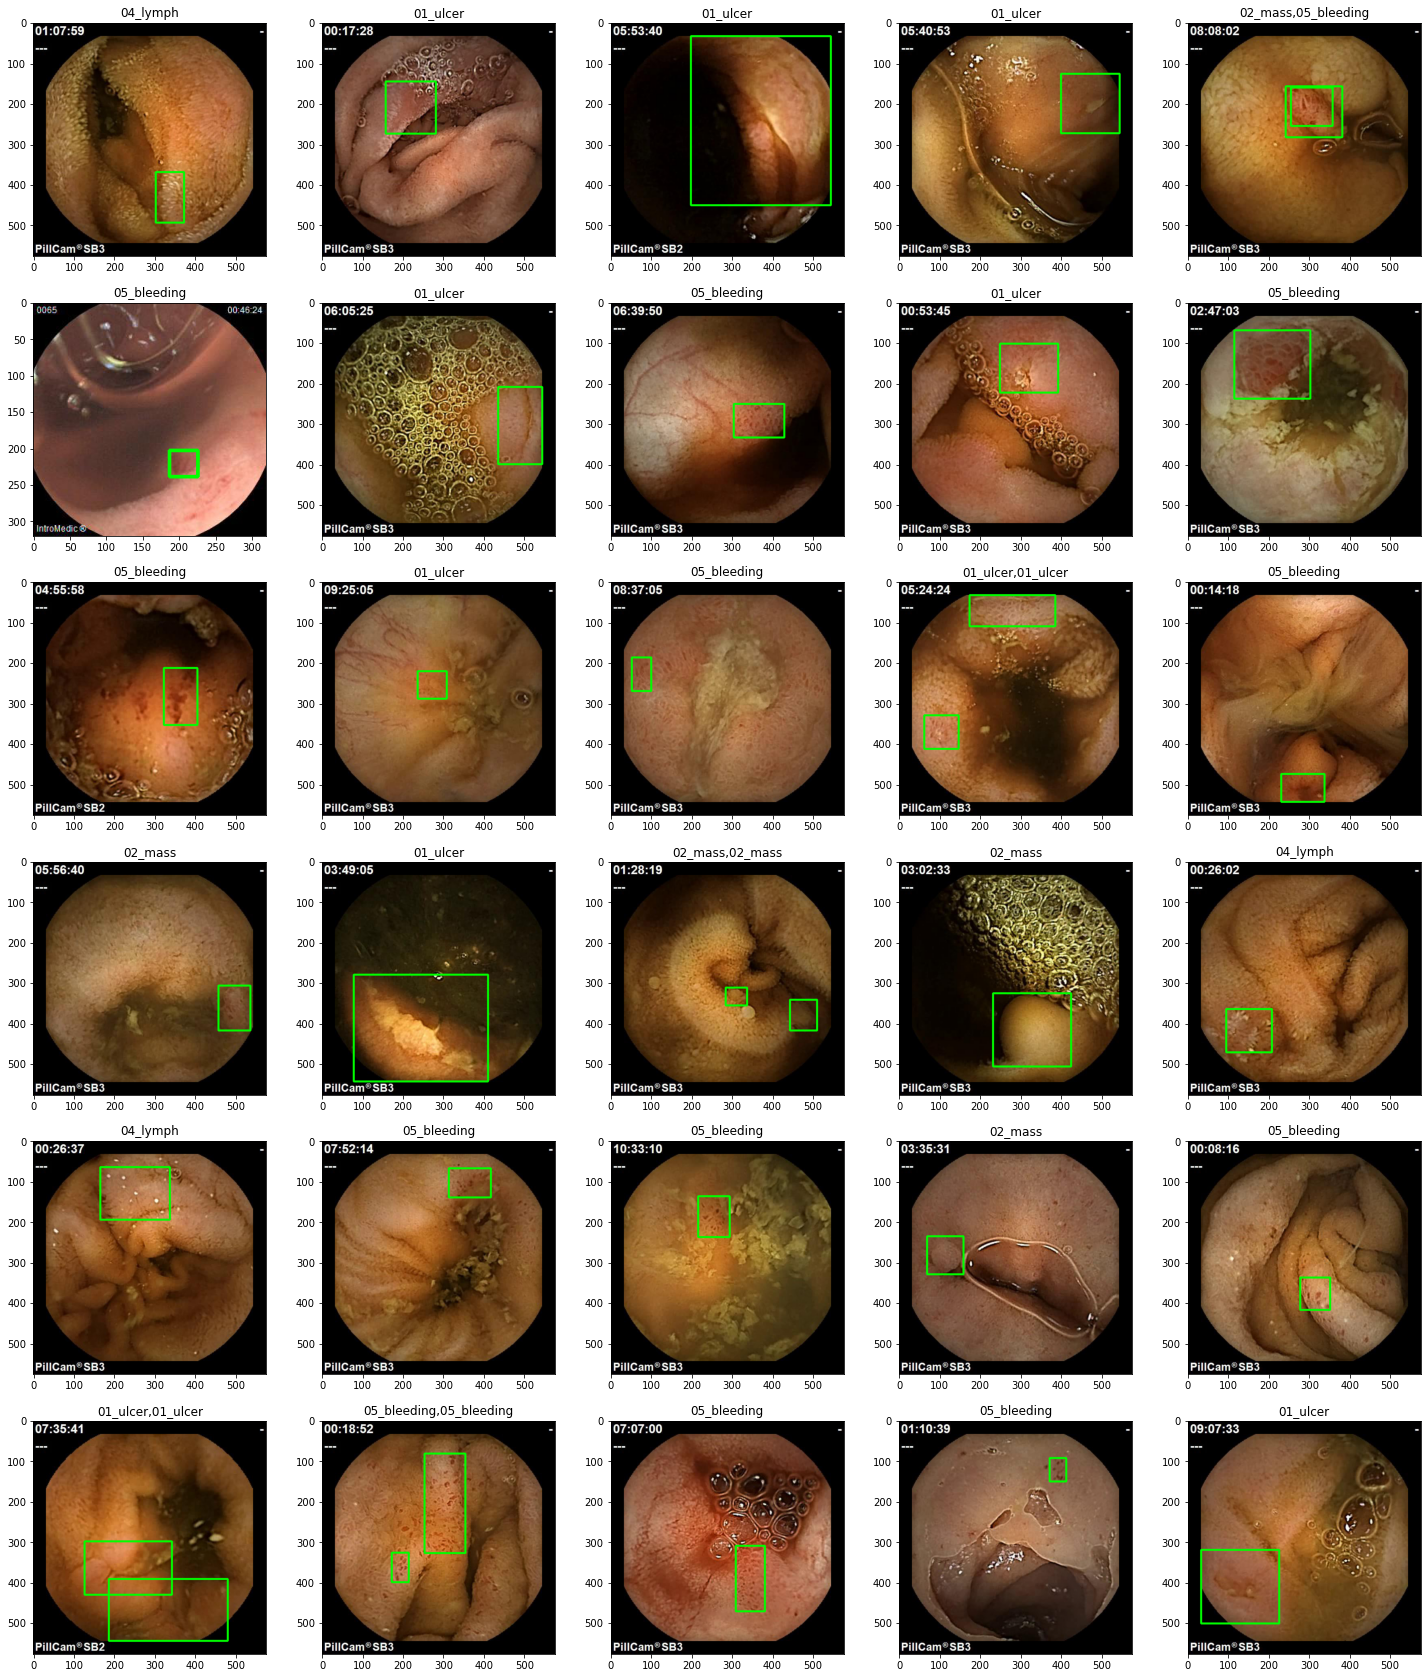

In [8]:
plt.figure(figsize=(25,30))
for i in range(30):
    plt.subplot(6,5,i+1)
    # base64 형식을 array로 변환
    img = Image.open(BytesIO(base64.b64decode(train_json_list[i]['imageData'])))
    img = np.array(img, np.uint8)
    title = []
    for shape in train_json_list[i]['shapes']:
        points = np.array(shape['points'], np.int32)
        cv2.polylines(img, [points], True, (0,255,0), 3)
        title.append(shape['label'])
    title = ','.join(title)
    plt.imshow(img)
    plt.subplot(6,5,i+1).set_title(title)
plt.show()

# 데이터 셋

In [12]:
class CustomDataset(Dataset):
    def __init__(self, json_list, mode='train'):
        self.mode = mode
        self.file_name = [json_file['file_name'] for json_file in json_list]
        if mode == 'train':
            self.labels = []
            for data in json_list:
                label = []
                for shapes in data['shapes']:
                    label.append(shapes['label'])
                self.labels.append(label)
            self.points = []
            for data in json_list:
                point = []
                for shapes in data['shapes']:
                    point.append(shapes['points'])
                self.points.append(point)
        self.imgs = [data['imageData'] for data in json_list]
        
        self.widths = [data['imageWidth'] for data in json_list]
        self.heights = [data['imageHeight'] for data in json_list]
        
        self.label_map ={
            '01_ulcer':1, '02_mass':2, '04_lymph':3, '05_bleeding':4
        }
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        file_name = self.file_name[i]
        img = Image.open(BytesIO(base64.b64decode(self.imgs[i])))
        img = self.transforms(img)
        
        target = {}
        if self.mode == 'train':
            boxes = []
            for point in self.points[i]:
                x_min = int(np.min(np.array(point)[:,0]))
                x_max = int(np.max(np.array(point)[:,0]))
                y_min = int(np.min(np.array(point)[:,1]))
                y_max = int(np.max(np.array(point)[:,1]))
                boxes.append([x_min, y_min, x_max, y_max])
            boxes = torch.as_tensor(boxes, dtype=torch.float32)

            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

            label = [self.label_map[label] for label in self.labels[i]]

            masks = []
            for box in boxes:
                mask = np.zeros([int(self.heights[i]), int(self.widths[i])], np.uint8)
                masks.append(cv2.rectangle(mask, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), 1, -1))

            masks = torch.tensor(masks, dtype=torch.uint8)

            target["boxes"] = boxes
            target["labels"] = torch.tensor(label, dtype=torch.int64)
            target["masks"] = masks
            target["area"] = area
            target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([i], dtype=torch.int64)
        if self.mode == 'test':
            target["file_name"] = file_name
        return img, target

In [13]:
train_dataset = CustomDataset(train_json_list, mode='train')
test_dataset = CustomDataset(test_json_list, mode='test')

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
train_dataset = CustomDataset(train_json_list, mode='train')

torch.manual_seed(1)
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=0,
    collate_fn=collate_fn)

# 모델

In [16]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    # COCO 에서 미리 학습된 인스턴스 분할 모델을 읽어옵니다
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    # 분류를 위한 입력 특징 차원을 얻습니다
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    # 미리 학습된 헤더를 새로운 것으로 바꿉니다
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    # 마스크 분류기를 위한 입력 특징들의 차원을 얻습니다
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    # 마스크 예측기를 새로운 것으로 바꿉니다
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# class 4 + background 1 = 5
num_classes = 5

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [18]:
device

device(type='cuda')

# 필요 클래스 및 함수 정의

## utils

In [19]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)
    
class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))
        
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

In [20]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

## engine

# 학습

In [21]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset

C:\Users\USER\AppData\Local\Temp/ipykernel_11464/1014257225.py:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  masks = torch.tensor(masks, dtype=torch.uint8)
C:\Users\USER\.conda\envs\torch\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [   0/7828]  eta: 12:23:16  lr: 0.000002  loss: 2.9368 (2.9368)  loss_classifier: 1.3786 (1.3786)  loss_box_reg: 0.0790 (0.0790)  loss_mask: 1.3458 (1.3458)  loss_objectness: 0.1235 (0.1235)  loss_rpn_box_reg: 0.0099 (0.0099)  time: 5.6971  data: 0.1725  max mem: 5802
Epoch: [0]  [ 100/7828]  eta: 1:20:49  lr: 0.000102  loss: 0.8890 (1.5434)  loss_classifier: 0.1626 (0.4811)  loss_box_reg: 0.1106 (0.0951)  loss_mask: 0.5527 (0.8582)  loss_objectness: 0.0529 (0.1006)  loss_rpn_box_reg: 0.0072 (0.0084)  time: 0.5957  data: 0.1753  max mem: 6079
Epoch: [0]  [ 200/7828]  eta: 1:17:13  lr: 0.000202  loss: 0.7765 (1.1769)  loss_classifier: 0.1761 (0.3222)  loss_box_reg: 0.1233 (0.1033)  loss_mask: 0.4273 (0.6709)  loss_objectness: 0.0375 (0.0732)  loss_rpn_box_reg: 0.0065 (0.0074)  time: 0.5749  data: 0.1675  max mem: 6079
Epoch: [0]  [ 300/7828]  eta: 1:15:37  lr: 0.000302  loss: 0.7405 (1.0372)  loss_classifier: 0.1717 (0.2719)  loss_box_reg: 0.1395 (0.1119)  loss_mask: 0.3900 

Epoch: [0]  [3000/7828]  eta: 0:48:00  lr: 0.001000  loss: 0.5203 (0.6263)  loss_classifier: 0.1071 (0.1401)  loss_box_reg: 0.1102 (0.1239)  loss_mask: 0.2792 (0.3389)  loss_objectness: 0.0073 (0.0187)  loss_rpn_box_reg: 0.0031 (0.0046)  time: 0.5806  data: 0.1609  max mem: 6079
Epoch: [0]  [3100/7828]  eta: 0:46:59  lr: 0.001000  loss: 0.5180 (0.6231)  loss_classifier: 0.1060 (0.1392)  loss_box_reg: 0.1082 (0.1238)  loss_mask: 0.2827 (0.3370)  loss_objectness: 0.0073 (0.0185)  loss_rpn_box_reg: 0.0033 (0.0046)  time: 0.5803  data: 0.1629  max mem: 6079
Epoch: [0]  [3200/7828]  eta: 0:45:58  lr: 0.001000  loss: 0.5058 (0.6202)  loss_classifier: 0.1004 (0.1383)  loss_box_reg: 0.1212 (0.1237)  loss_mask: 0.2734 (0.3354)  loss_objectness: 0.0085 (0.0183)  loss_rpn_box_reg: 0.0031 (0.0046)  time: 0.5948  data: 0.1742  max mem: 6079
Epoch: [0]  [3300/7828]  eta: 0:44:57  lr: 0.001000  loss: 0.5357 (0.6174)  loss_classifier: 0.1092 (0.1375)  loss_box_reg: 0.1112 (0.1235)  loss_mask: 0.2860 (

Epoch: [0]  [6000/7828]  eta: 0:17:59  lr: 0.001000  loss: 0.4785 (0.5673)  loss_classifier: 0.0889 (0.1216)  loss_box_reg: 0.1147 (0.1200)  loss_mask: 0.2687 (0.3072)  loss_objectness: 0.0075 (0.0143)  loss_rpn_box_reg: 0.0026 (0.0042)  time: 0.5831  data: 0.1637  max mem: 6079
Epoch: [0]  [6100/7828]  eta: 0:17:00  lr: 0.001000  loss: 0.5083 (0.5663)  loss_classifier: 0.0991 (0.1213)  loss_box_reg: 0.1181 (0.1200)  loss_mask: 0.2708 (0.3066)  loss_objectness: 0.0078 (0.0142)  loss_rpn_box_reg: 0.0033 (0.0042)  time: 0.5874  data: 0.1670  max mem: 6079
Epoch: [0]  [6200/7828]  eta: 0:16:00  lr: 0.001000  loss: 0.4788 (0.5651)  loss_classifier: 0.0963 (0.1210)  loss_box_reg: 0.1202 (0.1199)  loss_mask: 0.2599 (0.3060)  loss_objectness: 0.0070 (0.0141)  loss_rpn_box_reg: 0.0037 (0.0042)  time: 0.5847  data: 0.1631  max mem: 6079
Epoch: [0]  [6300/7828]  eta: 0:15:01  lr: 0.001000  loss: 0.4668 (0.5640)  loss_classifier: 0.0886 (0.1205)  loss_box_reg: 0.1076 (0.1198)  loss_mask: 0.2595 (

# 추론 및 제출

In [23]:
threshold = 0.8
results = {
    'file_name':[], 'class_id':[], 'confidence':[], 'point1_x':[], 'point1_y':[],
    'point2_x':[], 'point2_y':[], 'point3_x':[], 'point3_y':[], 'point4_x':[], 'point4_y':[]
}
model.eval()
for img, target in tqdm(test_dataset):
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    
    idx = np.where(prediction['scores'].cpu().numpy() > threshold)[0]
    for i in idx:
        x_min, y_min, x_max, y_max = prediction['boxes'].cpu().numpy()[i]
        class_id = prediction['labels'].cpu().numpy()[i]
        confidence = prediction['scores'].cpu().numpy()[i]
        
        results['file_name'].append(target['file_name'])
        results['class_id'].append(class_id)
        results['confidence'].append(confidence)
        results['point1_x'].append(x_min)
        results['point1_y'].append(y_min)
        results['point2_x'].append(x_max)
        results['point2_y'].append(y_min)
        results['point3_x'].append(x_max)
        results['point3_y'].append(y_max)
        results['point4_x'].append(x_min)
        results['point4_y'].append(y_max)

100%|████████████████████████████████████████████████████████████████████████████| 20874/20874 [14:37<00:00, 23.78it/s]


In [24]:
submission = pd.DataFrame(results)
submission.shape

(20115, 11)

In [26]:
submission.head()

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,test_200000.json,1,0.851158,177.333221,248.585068,240.784637,248.585068,240.784637,316.817719,177.333221,316.817719
1,test_200001.json,1,0.967352,118.037224,335.706421,255.597137,335.706421,255.597137,478.742188,118.037224,478.742188
2,test_200001.json,1,0.955554,413.460632,200.122757,513.156494,200.122757,513.156494,309.225189,413.460632,309.225189
3,test_200002.json,2,0.898482,222.598083,345.120697,312.336975,345.120697,312.336975,459.477478,222.598083,459.477478
4,test_200003.json,2,0.957250,132.443649,3.782288,310.013336,3.782288,310.013336,218.499756,132.443649,218.499756


In [27]:
submission.to_csv('baseline.csv', index=False)